# Anotação dos dados (*Data labeling*) - *Active Learning*

<div>
<img src="imagens/label.jpg" align="left" width="400"/>
</div>

---
### Rodrigo Fragoso 
- [**Linkedin**](https://www.linkedin.com/in/rodrigo-a-fragoso/) <br/>
- **Email** : rodrigoandradefragoso@gmail.com <br/>

### Objetivo
-  Como estamos trabalhando com dados novos e sem anotações, será necessário utilizar alguma metodologia para inserir anotações em algumas linhas.
-  O output esperado é um *dataframe* com uma nova coluna, no qual 1 representa recomendado e 0 não recomendado.
---

<a id='top'></a>
## Sumário

* [1 - Importações das bibliotecas](#t1)

* [2 - Active Learning (labeling)](#t2)
    * [2.1 - Processamento das variáveis de texto](#t2_1)
    * [2.2 - Random Forest *Vanilla* e Validação Cruzada](#t2_2)
    * [2.3 - Seleção dos exemplos difíceis](#t2_3)<br>
<br>

* [3 - Verificação dos resultados](#t3)



##     

<a id='t1'></a>
## 1 - Importações das bibliotecas
- [Sumário](#top)   
    - [Próximo](#t2)

### Para iniciarmos a extração será necessário o uso de algumas bibliotecas específicas, que serão importadas na célula abaixo:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

##     

<a id='t2'></a>
## 2 - Active Learning (labeling)
- [Sumário](#top) 
    - [Anterior](#t1)
    - [Próximo](#t2_1)

### Afim de simular um projeto real, no qual seriam necessários especialistas para realizar as anotações nos nossos dados e considerando que esse processo fosse custoso para a companhia, resolvemos simular a metodologia do *Active Learning*.
### O primeiro passo foi anotar 555 exemplos do nosso modelo e avaliar a sua performance. 
### Com o modelo treinado, é possível avaliar, em todo *dataset*, quais são os exemplos que ele está com maior dificuldade de classificar. Desse modo, poderíamos encaminhar estes exemplos considerados "difíceis" para o serviço de anotação, retreinar o modelo e provavelmente aumentar nossa performance de forma otimizada, tanto da visão operacional como financeira.
### Vale lembrar que no passo anterior também são incluídos alguns exemplos aleatórios, com o intuito de aumentar, em uma abordagem diferente da seleção dos difíceis, a capacidade de generalização do nosso modelo.

##     

<a id='t2_1'></a>
## 2.1 - Processamento das variáveis de texto
- [Sumário](#top) 
    - [Anterior](#t2)
    - [Próximo](#t2_2)

### Primeiro, é carregado o novo *dataset* com as 555 anotações. O *dropna( )* é utilizado para remover todos os exemplos que não contenham a anotação que está alocada na variável **y** e é validado com o argumento *shape( )* que ele foi carregado corretamente.

In [2]:
df = pd.read_csv('./dados_tratados/dados_tratados_555_labels.csv',delimiter=';').dropna(subset=['y'])
df.shape

(555, 96)

In [3]:
X= df.copy().drop(columns=['y'])
y= df['y'].copy()

### A *feature* *'good_reasons_to_buy'* foi escolhida por demonstrar uma maior variedade de palavras.

### Para processar esta variável foi utilizado o TfidfVectorizer( ), presente no **sklearn**. Esse transformador constrói uma *Bag of Words* (BoW), mas ao invés de contabilizar diretamente o valor exato de quantas palavras existem naquela *string*, como é feito com o CountVectorizer( ), ele utiliza uma abordagem que leva em conta a frequência daquela palavra em todos os exemplos e garante um maior valor para aquelas mais "raras" e um valor mais baixo para as comuns.

### A principal vantagem desse método é que as palavras que ocorrem com muita frequência geralmente possuem menor importância e acabam "recebendo" um valor mais irrelevante na nossa BoW, deixando maior espaço para *features* que aparecem apenas em certos grupos dos nossos exemplos e tendem a possuir um maior valor preditivo.

### Os dois argumentos da função possuem o seguinte objetivo:
* min_df(X) : apenas registrar palavras que apareçam em X exemplos;
* ngram_range(a,b) : indica quais grams iremos utilizar. Exemplo (1,3) irá utilizar o unigram (que é uma palvra), o bigram (que é o conjunto de duas palavras sequenciais) e o trigram.
* Foi escolhido um valor padrão para iniciar análise que será otimizado no próximo notebook.

###  Obs: O BoW costuma ter uma estrutura esparsa por possuir diversos valores nulos, desse modo ela é salva como uma matriz esparsa.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

title= X['good_reasons_to_buy'].fillna(' ')

title_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2))
title_bow = title_vec.fit_transform(title)

# print('Foram adicionadas {n} novas features'.format(n=title_bow_train.shape[1]))
title_bow.shape

(555, 4096)

In [5]:
X=X.copy().drop(columns=['shoes_name','link','image','bad_reasons_to_buy','good_reasons_to_buy'])

### Para juntar a BoW, que está como uma matriz esparsa, com o nosso *dataset* foi utilizada a funcão **hstack** do **scipy**, que realiza a junção horizontal desses dois conjuntos de dados.

In [6]:
from scipy.sparse import hstack

X_wtitle = hstack([X, title_bow])

##     

<a id='t2_2'></a>
## 2.2 - Random Forest *Vanilla* e Validação Cruzada
- [Sumário](#top) 
    - [Anterior](#t2_1)
    - [Próximo](#t2_3)

---

### Com o *dataset* pronto para uso, é possível criar o modelo para classificar os tênis que são recomendados para o usuário.

### Como temos uma quantidade relativamente pequena de dados anotados, foi escolhida a técnica de validação cruzada utilizando duas métricas: o AUC ROC-curve e a *Average Precision*, para avaliar a performance do nosso modelo.

### A validação cruzada foi escolhida por ser uma técnica que avalia robustamente a capacidade de generalização do modelo. Para isso, os dados são divididos em blocos (*Folds*) e são criadas diferentes combinações de treino/validação com esses blocos, afim de reduzir as chances de pegar apenas uma combinação enviesada, o que pode ocorrer quando utilizamos o train_test_split( ), principalmente em dados pequenos. A imagem abaixo, demonstra visualmente o processo de Validação Cruzada:
<div>
<img src="imagens/cv.png" align="left" width="400"/>
</div>


### A AUC- ROC curve é uma métrica que avalia a capacidade do modelo em distinguir as diferentes classes. Para isso, é calculada a área abaixo da curva ROC (*True positive x False Posistive*) e quanto maior o seu valor, melhor ele estará distinguindo os tênis que se adequam e não se adequam ao usuário.

### A precisão pode ser interpretada como: "dos exemplos que eu classifiquei como certos, quantos eram realmente certos?"
### Ao tratar de modelos de classificação, são geradas algumas "probabilidades" para cada exemplo, tradicionalmente se ela for maior que 0.5 ela é definida como positiva. Esse valor de corte é conhecido como *threshold* e pode ser alterado. Ao testar todos *thresholds* num intervalo de (0,1) são gerados diversos valores de precisão para o mesmo modelo, a média de todos esses valores é denominada *Average Precision*, sendo a métrica que será utilizada.
---


### Com o método de validação e as métricas definidas, foi criada uma função que atua da seguinte forma:
* **train_roc_viz( )**:
    1. Com o modelo selecionado, é feita a validação cruzada naqueles dados e são salvos os valores da *average precision e AUC-ROC* por cada *fold*;
    2. São calculados os valores médios das metricas utilizadas;
    3. É feita uma visualização para facilitar a interpretação dos resultados
* Obs: o modelo é um *input* nesta função

In [7]:
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(10,7)})

In [8]:
from scipy import interp
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve ,auc , confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold

def train_roc_viz(X,y,model):
    resultados_aps=[]
    resultados_roc=[]
    tprs=[]
    i=1

    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)

    for train,valid in kf.split(X):

        Xtr, Xvld = X.toarray()[train,:], X.toarray()[valid,:]
        ytr, yvld = y.iloc[train], y.iloc[valid]

        rf.fit(Xtr,ytr)
        p=rf.predict(Xvld)

        aps=average_precision_score(yvld, p)
        resultados_aps.append(aps)
        roc=roc_auc_score(yvld, p)
        resultados_roc.append(roc)

        # Roc by fold plt
        f = plt.figure(1)
        fpr, tpr, t = roc_curve(yvld, p)   
        mean_fpr=np.linspace(0,1,100)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC Fold %d (AUC = %0.4f APS = %0.4f)' % (i,roc,aps))

        i=i+1
        
    # Roc average plt
    f = plt.figure(1)
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.4f APS = %0.4f)' % (np.mean(resultados_roc),np.mean(resultados_aps)),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str('Random Forest')+' ROC curve by folds')
    plt.legend(loc="lower right")

### Para a avaliação é utilizada uma Random Forest *Vanilla*, que possui valores comuns dos hiperparâmetros. O class_weight=1 é utilizado por estarmos tratando de dados desbalanceados, então este argumento propõe compensar este fato dando mais "importância" para os valores menos frequentes.

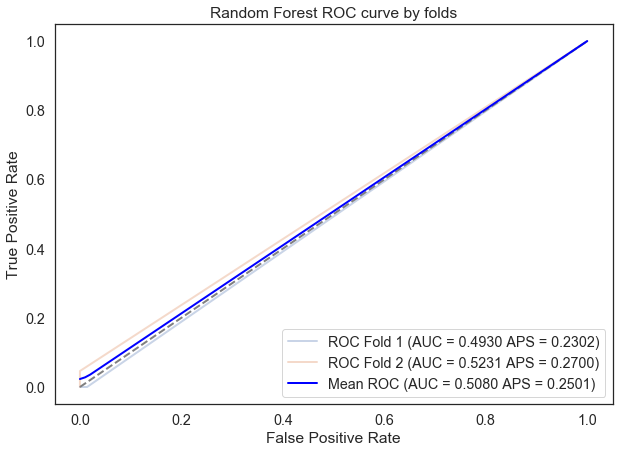

In [9]:
rf= RandomForestClassifier(n_estimators=1000,min_samples_leaf=1,class_weight="balanced", n_jobs=-1, random_state=1)

train_roc_viz(X_wtitle,y,rf)

### O modelo não teve uma perfomance excelente, o que tentará ser melhorado com o *Active Learning*

##        

<a id='t2_3'></a>
## 2.3 - Seleção dos exemplos difíceis
- [Sumário](#top) 
    - [Anterior](#t2_2)
    - [Próximo](#t3)

### Dando prosseguimento a metodologia, iremos treinar uma Random Forest com os mesmos parâmetros, mas utilizando todos os dados disponíveis até o momento

In [10]:
rf.fit(X_wtitle,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Para selecionar novos exemplos para anotação, foram utilizados apenas aqueles que ainda não tinham anotações, os *unlabeleds*

In [11]:
df_unlabeled = pd.read_csv('./dados_tratados/dados_tratados_555_labels.csv',delimiter=';')
df_unlabeled = df_unlabeled[df_unlabeled['y'].isnull()].dropna(how='all').drop(columns=['y'])

In [12]:
df_unlabeled.shape

(1722, 95)

### Aqui foi feita a mesma transformação de texto utilizada anteriormente, treinada com os dados anotados.

In [13]:
X2=df_unlabeled

title_train = df_unlabeled['good_reasons_to_buy'].fillna(' ')

title_bow_train = title_vec.transform(title_train)

X2=X2.drop(columns=['shoes_name','link','image','bad_reasons_to_buy','good_reasons_to_buy'])

from scipy.sparse import hstack, vstack

X2_wtitle = hstack([X2, title_bow_train])

In [14]:
X2.shape

(1722, 90)

### Como foi dito, é possível adquirir as "probabilidades" geradas pelo modelo. No **scikit learn**, isso é feito atraves da função predict_proba( ). Com ela, são geradas os novos valores para os exemplos não anotados

In [15]:
p2 = rf.predict_proba(X2_wtitle)[:, 1]
X2['pred']=p2

In [16]:
X2.shape

(1722, 91)

### É feito um *merge* com os dados originais, com o intuito de resgatar as informações que foram excluídas para o treinamento como nome do tênis, link, link da imagem e outras

In [17]:
cols_to_use = df_unlabeled.columns.difference(X2.columns)
result2=pd.merge(df_unlabeled[cols_to_use], X2, left_index=True, right_index=True)

In [18]:
result2.shape

(1722, 96)

### Para selecionar os exemplos difíceis, foram escolhidos aqueles que tinham uma probabilidade perto do limiar de 0.5, que representa a área com maior dificuldade de predição do modelo. Os ranges escolhidos para atingir um valor significante de exemplos foi de 0.5 +- 0.15.

In [19]:
mask=(result2['pred']>0.35) & (result2['pred']<0.65)
print('Selecionados {} exemplos dentro do range especificado'.format(mask.sum()))

Selecionados 144 exemplos dentro do range especificado


### Como foi dito, para aumentar a capacidade de generalização foram escolhidos mais 56 exemplos aleatórios para serem anotados.

In [20]:
hard_to_predict= result2[mask]
aleatory= result2[~mask].sample(56,random_state=19)

hard_to_predict.append(aleatory).to_csv('./dados_tratados/dados_tratados_active_learning.csv',sep=';')

In [21]:
hard_to_predict.append(aleatory).shape

(200, 96)

##        

<a id='t3'></a>
## 3 - Verificação dos resultados
- [Sumário](#top)   
    - [Anterior](#t2_3)

### Por fim, os dados anotados foram agregados em um único *dataframe* e o modelo foi treinado e avaliado da mesma maneira

In [22]:
df1 = pd.read_csv('./dados_tratados/dados_tratados_555_labels.csv',delimiter=';').dropna(subset=['y'])
df1 = df1[df1['y'].notnull()]
df1['novo'] = 0
df1.shape

(555, 97)

In [23]:
df2 = pd.read_csv("./dados_tratados/dados_tratados_active_learning_labels.csv",index_col=[0], delimiter=';')
df2 = df2[df2['y'].notnull()]
df2['novo'] = 1
df2=df2[df1.columns]
df2.shape

(200, 97)

In [24]:
df_updated=pd.concat([df1, df2])

In [25]:
X_up= df_updated.copy().drop(columns=['y'])
y_up= df_updated['y'].copy()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

title= X_up['good_reasons_to_buy'].fillna(' ')

title_vec = TfidfVectorizer(min_df=3, ngram_range=(1,2))
title_bow = title_vec.fit_transform(title)

# print('Foram adicionadas {n} novas features'.format(n=title_bow_train.shape[1]))
title_bow.shape

(755, 5316)

In [27]:
X_up=X_up.copy().drop(columns=['shoes_name','link','image','bad_reasons_to_buy','good_reasons_to_buy'])

In [28]:
from scipy.sparse import hstack

X_up_wtitle = hstack([X_up, title_bow])

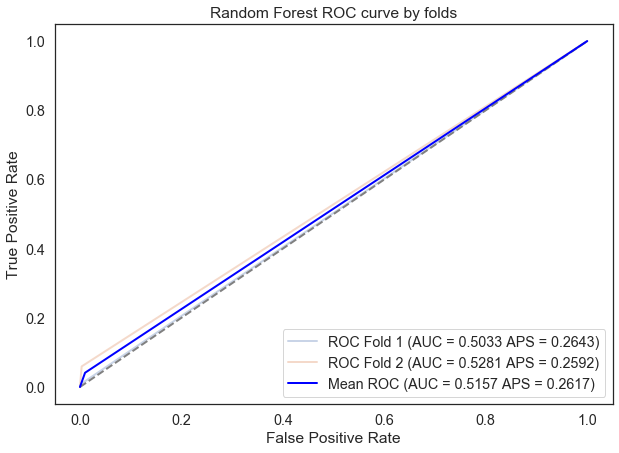

In [29]:
train_roc_viz(X_up_wtitle,y_up,rf)

### Podemos perceber que o Active Learning trouxe uma melhoria muito discreta na nossa performance. Isto pode ter acontecido por estarmos lidando com uma quantidade muito pequena de dados. Mesmo assim, agora nós temos um *dataset* de treinamento mais robusto e que provavelmente trará bons resultados na etapa de otimização e produção.